## The Goal: Allocate portfolio into 10 stocks in a manner that maximizes the Sharpe Ratio.

####  You may use any libraries in addition to pandas and numpy. Coding in another language of your preference is also acceptable. The Sharpe Ratio is defined as the following:
$$
Sharpe Ratio = \frac{R_p - R_f}{\sigma _p}
$$

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as spy 
from scipy.stats import norm
from scipy.optimize import minimize
import seaborn as sb 
import random
import time

#### The following 10 stocks' historical (dividend & stock-split adjusted) prices are provided in addition to the S&P 500 Index (approximated by the SPY ETF) as well as the 2 and 10 year treasury par rates. For the sake of this exercise, please do not allocate to the S&P 500 or any of the treasuries, they only serve the purpose of benchmarking & calculating the Sharpe Ratio.

In [3]:
# IMPORT DATA 
#fp = "C:\\Users\\trader29\\Downloads\\Coding Assignment Data.csv"
fp = "C:\\Users\\samue\\OneDrive - University of Toronto\\MFE\\Reports\\Coding Assignment\\V2\\Coding Assignment Data.csv"
data = pd.read_csv(fp)

<Axes: xlabel='Date'>

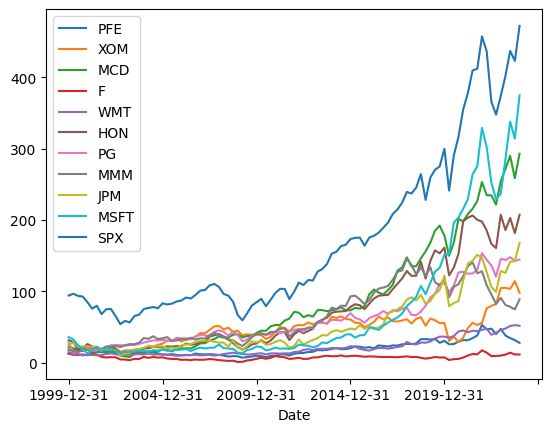

In [4]:
# PLOT STOCK DATA 
plot_data = data.copy()
plot_data.set_index('Date', inplace=True)
tickers = ["PFE","XOM","MCD","F","WMT","HON","PG","MMM","JPM","MSFT"]

plot_data[tickers + ["SPX"]].plot()

<Axes: xlabel='Date'>

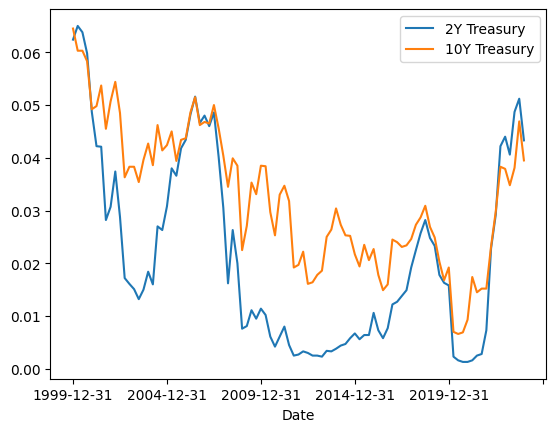

In [5]:
plot_data[['2Y Treasury', '10Y Treasury']].plot()

### Part A) For all but the treasury securities, calculate the quarterly returns.

In [6]:
# CREATE FUNCTION THAT CALCULATES RETURN 
def calculate_return(df, exclude):
    
    return_df = pd.DataFrame()

    for series in data.columns: 
        if series in exclude_series: 
            ## ignore the treasury securities
            pass 
        else:     
            ## Calculate the quarterly return 
            # select the series
            price_vector = data[series].tolist()
            series_length = len(price_vector)

            # slice the vector for computation 
            price_vector_t = price_vector[1:series_length]
            price_vector_t_1 = price_vector[0:(series_length-1)]
            
            # calculate the return vector 
            R_t = []

            for i in range(series_length-1): 
                R_t.append((price_vector_t[i]/price_vector_t_1[i])-1)
            
            return_df.insert(0, series, R_t)

    return return_df

In [7]:
# CALCULATE Q-Q RETURNS FOR TICKERS 
exclude_series = ["Date", "2Y Treasury", "10Y Treasury"]

return_QQ = calculate_return(data, exclude_series)
return_QQ.head()

,PFE,XOM,MCD,F,WMT,HON,PG,MMM,JPM,MSFT,SPX
0,0.130028,-0.026380,-0.072868,-0.129620,-0.182030,-0.082951,-0.480609,-0.088128,0.128634,-0.089936,0.026343
1,0.315387,0.011874,-0.118729,-0.016736,0.021194,-0.358468,0.004659,-0.055534,-0.203393,-0.247059,-0.031418
2,-0.062117,0.141346,-0.083491,0.047767,-0.163947,0.063164,0.187753,0.105856,0.009728,-0.246094,-0.009073
3,0.026157,-0.019617,0.133666,-0.069968,0.105124,0.332925,0.176325,0.332125,-0.009458,-0.280829,-0.084303
4,-0.107603,-0.063410,-0.219118,0.212752,-0.048222,-0.134234,-0.198010,-0.132290,-0.004590,0.260806,-0.107781


In [8]:
# CREATE FUNCTION THAT CREATES NICE QUARTERLY DATES 
def amend_quarterly_dates(dates):
    return_dates_quarterly = []

    for i in range(len(dates)): 
        split_list = dates[i].split("-") ## YYYY, MM, DD 
        if split_list[1] == "03": 
            return_dates_quarterly.append("Q1" + " " + split_list[0])
        elif split_list[1] == "06": 
            return_dates_quarterly.append("Q2" + " " + split_list[0])
        elif split_list[1] == "09": 
            return_dates_quarterly.append("Q3" + " " + split_list[0])
        else: 
            return_dates_quarterly.append("Q4" + " " + split_list[0])

    return return_dates_quarterly


In [9]:
# ADD NICELY FORMATED QUARTERLY DATES TO QQ RETURN DATA FRAME
return_dates = data["Date"].tolist()
return_dates = return_dates[1:len(return_dates)]

return_dates_quarterly = amend_quarterly_dates(return_dates)

present_return_df = return_QQ.copy()

present_return_df.insert(0, "Date", return_dates_quarterly)

present_return_df.set_index('Date', inplace=True)

present_return_df

,PFE,XOM,MCD,F,WMT,HON,PG,MMM,JPM,MSFT,SPX
Date,,,,,,,,,,,
Q1 2000,0.130028,-0.026380,-0.072868,-0.129620,-0.182030,-0.082951,-0.480609,-0.088128,0.128634,-0.089936,0.026343
Q2 2000,0.315387,0.011874,-0.118729,-0.016736,0.021194,-0.358468,0.004659,-0.055534,-0.203393,-0.247059,-0.031418
Q3 2000,-0.062117,0.141346,-0.083491,0.047767,-0.163947,0.063164,0.187753,0.105856,0.009728,-0.246094,-0.009073
Q4 2000,0.026157,-0.019617,0.133666,-0.069968,0.105124,0.332925,0.176325,0.332125,-0.009458,-0.280829,-0.084303
Q1 2001,-0.107603,-0.063410,-0.219118,0.212752,-0.048222,-0.134234,-0.198010,-0.132290,-0.004590,0.260806,-0.107781
...,...,...,...,...,...,...,...,...,...,...,...
Q4 2022,0.180968,0.273485,0.148540,0.049247,0.093215,0.289749,0.208995,0.100482,0.294735,0.032614,0.075091
Q1 2023,-0.196437,0.001848,0.067144,0.151705,0.043838,-0.103442,-0.012780,-0.109583,-0.021085,0.205163,0.075412
Q2 2023,-0.091252,-0.013490,0.067237,0.215791,0.074424,0.091402,0.026902,-0.030396,0.124867,0.183782,0.086914


In [10]:
present_return_df.describe()

,PFE,XOM,MCD,F,WMT,HON,PG,MMM,JPM,MSFT,SPX
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.013927,0.024736,0.032947,0.023603,0.016320,0.029489,0.022450,0.022545,0.031750,0.034248,0.020471
std,0.112173,0.119697,0.107991,0.235780,0.080921,0.137881,0.098863,0.108951,0.153414,0.138530,0.083622
min,-0.214404,-0.448049,-0.379262,-0.559615,-0.182030,-0.381564,-0.480609,-0.237010,-0.434017,-0.299041,-0.217499
25%,-0.059158,-0.040834,-0.020778,-0.102037,-0.037597,-0.052866,-0.021873,-0.056021,-0.039363,-0.061176,-0.019755
50%,0.004511,0.023008,0.036090,0.004644,0.023277,0.034593,0.016501,0.022147,0.033759,0.041987,0.029330
75%,0.073495,0.095796,0.085836,0.149280,0.066876,0.107427,0.081012,0.099718,0.113059,0.134043,0.075171
max,0.384988,0.377441,0.525588,1.307986,0.263758,0.332925,0.208995,0.332125,0.462103,0.334858,0.203388


### Part b) Randomly choose weights to allocate to the 10 stocks, hold those weights constant and averaging the returns across all periods. Repeat this for 1000 times, what is the likelihood of beating the S&P 500 on a Sharpe Ratio basis?

#### Note 1: The weights have to add up to 1 (exhaust all capital) and no negative weights (no short-selling) are allowed.
#### Note 2: For calculating the Sharpe Ratio, annualize your average return and volatility and use either the 2 or 10 year treasuries as the risk free rate.

In [12]:
# CALCULATE KEY BENCHMARK VARIABLES 
# risk free rate 
risk_free_rate = data["2Y Treasury"].mean()

# calculate sharpe ratio for S&P 500
SPX_return = (1 + return_QQ["SPX"].mean())**4 - 1  
SPX_std = return_QQ["SPX"].std() * 2

SPX_sharpe = (SPX_return - risk_free_rate)/SPX_std
print("SPX Mean Return:", np.round(SPX_return,2))
print("SPX STD:", np.round(SPX_std,2))
print("SPX Sharpe:", np.round(SPX_sharpe, 2))
print("Risk Free Rate:", np.round(risk_free_rate, 2))

SPX Mean Return: 0.08
SPX STD: 0.17
SPX Sharpe: 0.38
Risk Free Rate: 0.02


In [15]:
### EQUAL PORTFOLIO STANDARD DEVIATION 
equal_weights = pd.Series([(1/len(tickers))] * len(tickers))

equal_portfolio_QQ = pd.DataFrame(np.dot(return_QQ[tickers], equal_weights))

equal_portfolio_mean = equal_portfolio_QQ.mean() * 4 
equal_portfolio_std = equal_portfolio_QQ.std() * 2

equal_portfolio_sharpe = (equal_portfolio_mean - risk_free_rate)/equal_portfolio_std

print("EQ Return:", np.round(equal_portfolio_mean,2))
print("EQ STD:", np.round(equal_portfolio_std,2))
print("EQ Sharpe:", np.round(equal_portfolio_sharpe, 2))
print("Risk Free Rate:", np.round(risk_free_rate, 2))

EQ Return: 0    0.1
dtype: float64
EQ STD: 0    0.17
dtype: float64
EQ Sharpe: 0    0.47
dtype: float64
Risk Free Rate: 0.02


In [16]:
# CALCULATE THE ANNUALIZED RETURN FOR TICKERS 
ticker_return = return_QQ[tickers].mean() * 4  
ticker_cov = return_QQ[tickers].cov() * 2

In [17]:
# CREATE A FUNCTION THAT SIMULATES X PORTFOLIOS BASED OF QUARTERLY RETURN DATA 
def simulate_portfolios(n, stocks, mean_return, cov, r_f): 

    simluated_portfolios = pd.DataFrame(columns=['returns', 'std', 'sharpe'], index = range(n))
    weights = []
    for i in range(n):
        # generate random vector that sums to 1 and has values between (0,1)
        rand_vec = np.random.random(len(stocks))
        rand_vec_norm = rand_vec/sum(rand_vec)

        # calculate portfolio return  
        random_portfolio_return = np.dot(rand_vec_norm, mean_return.tolist())
        
        # calculate portfolio standard deviation
        random_portfolio_std = np.sqrt(np.dot(np.dot(rand_vec_norm.T,cov),rand_vec_norm)) 

        # calculate sharpe ratio 
        random_portfolio_sharpe = (random_portfolio_return - r_f)/random_portfolio_std
        
        # append to data frame 
        simluated_portfolios.loc[i, "returns"] = random_portfolio_return
        simluated_portfolios.loc[i,"std"] = random_portfolio_std
        simluated_portfolios.loc[i,"sharpe"] = random_portfolio_sharpe
        weights.append(rand_vec_norm)

    max_sharpe = max(simluated_portfolios["sharpe"])

    index = simluated_portfolios.index[simluated_portfolios["sharpe"] == max_sharpe].tolist()[0]

    opt_weights = weights[index]

    opt_weights_dict = {"tickers": tickers, "weights": opt_weights}
        
    return simluated_portfolios, weights, max_sharpe, opt_weights_dict

In [19]:
# RUN SIMULATION 
output, weights, max_sharpe, opt_weights = simulate_portfolios(1000, tickers, ticker_return, ticker_cov, risk_free_rate)

<Axes: xlabel='std', ylabel='returns'>

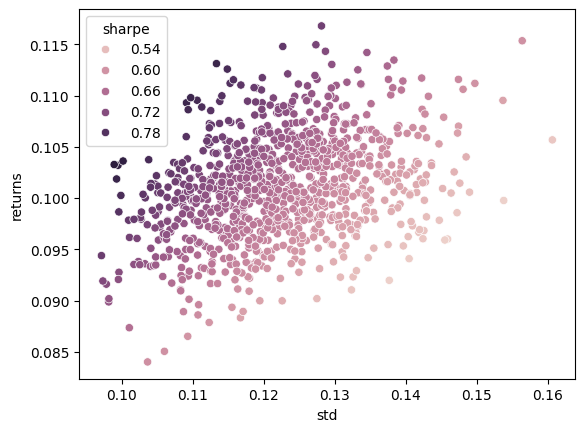

In [20]:
# PLOT SIMULATED DATA 
X = output["std"]
Y = output["returns"]
Z = output["sharpe"]

sb.scatterplot(data= output, x=X, y=Y, hue= Z)

In [21]:
# FIND THE MAX SHARPE VALUE FROM THE SIMULATION AND PORTFOLIO WEIGHTS 

present_weights = pd.DataFrame(opt_weights)
present_weights["weights"] = np.round(present_weights["weights"],2) *100

print("Max Sharpe:", np.round(max_sharpe, 2))
print("Max Sharpe Portfolio Weights:")
print(present_weights)


Max Sharpe: 0.83
Max Sharpe Portfolio Weights:
  tickers  weights
0     PFE      1.0
1     XOM     22.0
2     MCD     20.0
3       F      0.0
4     WMT     15.0
5     HON      2.0
6      PG     16.0
7     MMM      9.0
8     JPM      6.0
9    MSFT      9.0


As seen in the figure above, it is fairly likely that a random portfolio will beat the index on a Sharpe Ratio basis. 

### Part c) Divide the data in half and treat the first 12 years as your "training" data set. Calculate the covariance matrix of the training set for the 10 stocks and optimize weights to achieve highest Sharpe Ratio.
#### Note 3: The variance of a portfolio of assets is calculated as: 
$$ PortfolioVar = w^T \Sigma w $$
#### *where w is a column vector of weights, and sigma is the covariance matrix of the portfolio.

In [22]:
# CREATE TRAINING DATA 
training_data = return_QQ[0:48]
training_data.describe()

,PFE,XOM,MCD,F,WMT,HON,PG,MMM,JPM,MSFT,SPX
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.005922,0.025689,0.032975,0.017824,0.003531,0.018796,0.017721,0.024745,0.012554,0.000720,0.005211
std,0.115832,0.094422,0.130840,0.284879,0.080471,0.165283,0.114119,0.119645,0.167712,0.157519,0.090121
min,-0.214404,-0.215418,-0.379262,-0.559615,-0.182030,-0.381564,-0.480609,-0.237010,-0.434017,-0.299041,-0.217499
25%,-0.069291,-0.026586,-0.023763,-0.133846,-0.051738,-0.087896,-0.022678,-0.059514,-0.047164,-0.089729,-0.035428
50%,-0.008857,0.023464,0.026374,-0.033856,0.017388,0.022189,0.023992,0.021711,0.008656,-0.003390,0.016224
75%,0.074431,0.099730,0.110298,0.151483,0.050728,0.134893,0.081012,0.104949,0.082218,0.085213,0.061215
max,0.315387,0.190814,0.525588,1.307986,0.164424,0.332925,0.187753,0.332125,0.462103,0.334858,0.164589


In [29]:
# CALCULATE MEAN & COV FOR TRAINING DATA 
training_data_returns = training_data[tickers].mean() * 4 # annualize quarterly data 
training_data_cov = training_data[tickers].cov() * np.sqrt(4) # annualize quarterly data 
training_data_cov

,PFE,XOM,MCD,F,WMT,HON,PG,MMM,JPM,MSFT
PFE,0.026834,0.008547,0.007177,0.024804,0.005089,0.012895,0.004040,0.009642,0.016776,0.004574
XOM,0.008547,0.017831,0.009115,0.013232,0.000581,0.018558,0.005368,0.008547,0.008819,0.008551
MCD,0.007177,0.009115,0.034238,0.022073,0.007452,0.022495,0.009511,0.006954,0.021528,0.008364
F,0.024804,0.013232,0.022073,0.162312,0.001165,0.046853,0.012090,0.030230,0.053402,0.044584
WMT,0.005089,0.000581,0.007452,0.001165,0.012951,0.008353,0.005436,0.003518,0.007124,0.004391
HON,0.012895,0.018558,0.022495,0.046853,0.008353,0.054637,0.012449,0.027682,0.033130,0.019337
PG,0.004040,0.005368,0.009511,0.012090,0.005436,0.012449,0.026046,0.011820,0.005928,0.001832
MMM,0.009642,0.008547,0.006954,0.030230,0.003518,0.027682,0.011820,0.028630,0.017608,0.009719
JPM,0.016776,0.008819,0.021528,0.053402,0.007124,0.033130,0.005928,0.017608,0.056255,0.023614
MSFT,0.004574,0.008551,0.008364,0.044584,0.004391,0.019337,0.001832,0.009719,0.023614,0.049624


In [26]:
# USING THE SIMULATION METHOD WE CAN FIND A GOOD APPROXIMATION OF THE OPTIMAL SHARPE RATIO, INCREASING THE NUMBER OF TRIALS 
training_output, training_weights, max_sharpe_training, opt_weights_training = simulate_portfolios(100000, tickers, training_data_returns, training_data_cov, risk_free_rate)

<Axes: xlabel='std', ylabel='returns'>

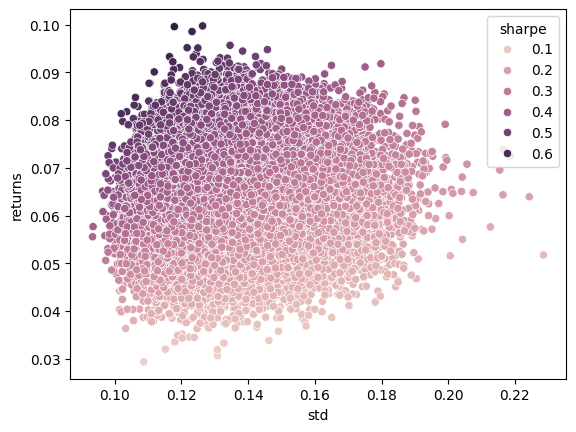

In [27]:
# PLOT TRAINING SIMULATION RESULTS  
X = training_output["std"]
Y = training_output["returns"]
Z = training_output["sharpe"]

sb.scatterplot(data= output, x=X, y=Y, hue= Z)

In [21]:
present_weights = pd.DataFrame(opt_weights_training)
present_weights["weights"] = np.round(present_weights["weights"],2) *100

print("Max Sharpe:", np.round(max_sharpe_training, 2))
print("Max Sharpe Portfolio Weights:")
print(present_weights)

Max Sharpe: 0.63
Max Sharpe Portfolio Weights:
  tickers  weights
0     PFE      5.0
1     XOM     24.0
2     MCD     24.0
3       F      0.0
4     WMT      5.0
5     HON      1.0
6      PG     23.0
7     MMM     13.0
8     JPM      4.0
9    MSFT      1.0


We can achieve a good approximation of the Sharpe ratio by increasing the sample size of random portfolios. Increasing the sample size to 100,000 we have that the maximum sharpe ratio is 0.63. It should be noted that other methods can be used to directly solve for the sharpe ratio such as: solving the quadratic programing problem directly with an LU decomposition, using an sci-py's SLSQP method, or a gradient descent algorithm. This method was chosen to allow for an analytical investigation of part g and because of its simplicity.

### Part d) Holding the weights you calculated in part c) throughout the last 12 years of "testing" data set, what is your average return, volatility, and achieved Sharpe Ratio? Did it beat the S&P 500?

In [30]:
# CREATE TESTING DATA 
testing_data = return_QQ[tickers][48:]

# CALCULATE RETURN AND COV
optimal_weights = pd.Series(opt_weights_training["weights"]) 
testing_return_QQ = np.dot(testing_data, optimal_weights)

testing_return_mean = testing_return_QQ.mean() * 4 
testing_return_std = testing_return_QQ.std() * 2

testing_return_sharpe = (testing_return_mean - risk_free_rate)/testing_return_std
testing_return_sharpe

print("Testing Return:", np.round(testing_return_mean,2))
print("Testing STD:", np.round(testing_return_std,2))
print("Testing Sharpe:", np.round(testing_return_sharpe, 2))
print("Risk Free Rate:", np.round(risk_free_rate, 2))

Testing Return: 0.11
Testing STD: 0.14
Testing Sharpe: 0.62
Risk Free Rate: 0.02


In [31]:
# CREATE FUNCTION THAT CALCULATES CUMULATIVE RETURN  
def cumulative_return(series): 
    cm_return = []
    for i in range(len(series)): 
        if i == 0: 
            cm_return.append(series[i])
        else: 
            sub_series = series[0:i+1]
            #print(sub_series)
            sub_cm_return = 0 
            
            for j in range(len(sub_series)): 
                if j == 0: 
                    sub_cm_return += (1 + sub_series[j])

                else:
                    sub_cm_return *= (1 + sub_series[j])
                #print(sub_cm_return)
            sub_cm_return -= 1 

            cm_return.append(sub_cm_return)
    return cm_return

<Axes: xlabel='Date'>

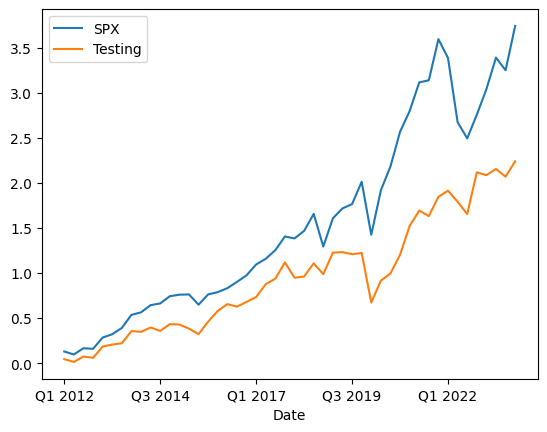

In [32]:
# CALCULATE THE CUMULATIVE RETURN OF THE SPX AND OPTIMAL PORTFOLIO OVER TESTING YEARS 
SPX_cm_return = cumulative_return(return_QQ["SPX"][48:].tolist())
testing_cm_return = cumulative_return(testing_return_QQ.tolist())

testing_dates = pd.Series(amend_quarterly_dates(return_dates[48:]))

dict = {
    "Date": testing_dates, 
    "SPX": SPX_cm_return, 
    "Testing": testing_cm_return
}
temp = pd.DataFrame(dict)
temp.set_index('Date', inplace=True)
temp.plot()

As shown in the figure above, the portfolio failed to outperform the SPX index. 

### Part e) Suppose time have reversed, your "training" set is now the "testing" set, can you draw the same conclusion as part d? What might have changed and what does that suggest about the strategy?

In [34]:
# CREATE TRAINING DATA 
training_data = return_QQ[48:]
training_data.describe()

,PFE,XOM,MCD,F,WMT,HON,PG,MMM,JPM,MSFT,SPX
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.021931,0.023782,0.032920,0.029382,0.029109,0.040182,0.027178,0.020346,0.050945,0.067776,0.035730
std,0.109020,0.141570,0.080332,0.176473,0.080163,0.104284,0.081773,0.098328,0.136720,0.108078,0.074408
min,-0.196437,-0.448049,-0.158014,-0.471813,-0.177452,-0.240033,-0.130557,-0.217826,-0.350014,-0.165035,-0.195249
25%,-0.030415,-0.049096,-0.017502,-0.065967,-0.016459,-0.019752,-0.021250,-0.050267,-0.022246,0.002757,0.008855
50%,0.022422,0.017463,0.037835,0.021022,0.031937,0.050221,0.013272,0.029044,0.051747,0.069144,0.042938
75%,0.073495,0.077267,0.073555,0.123250,0.072181,0.089369,0.079174,0.099301,0.120662,0.142941,0.078254
max,0.384988,0.377441,0.208427,0.474194,0.263758,0.298203,0.208995,0.189744,0.392811,0.294000,0.203388


In [42]:
# CALCULATE MEAN & COV FOR TRAINING DATA 
training_data_returns = training_data[tickers].mean() * 4 # annualize quarterly data 
training_data_cov = training_data[tickers].cov() * 2 # annualize quarterly data 

In [43]:
# USING THE SIMULATION METHOD WE CAN FIND A GOOD APPROXIMATION OF THE OPTIMAL SHARPE RATIO, INCREASING THE NUMBER OF TRIALS 
training_output, training_weights, max_sharpe_training, opt_weights_training = simulate_portfolios(100000, tickers, training_data_returns, training_data_cov, risk_free_rate)

<Axes: xlabel='std', ylabel='returns'>

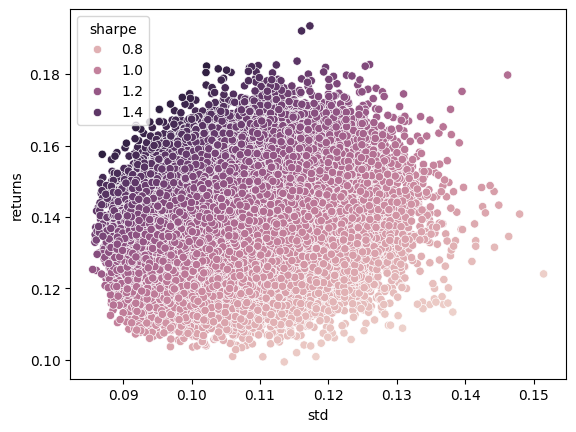

In [44]:
# PLOT TRAINING SIMULATION RESULTS  
X = training_output["std"]
Y = training_output["returns"]
Z = training_output["sharpe"]

sb.scatterplot(data= output, x=X, y=Y, hue= Z)

In [45]:
present_weights = pd.DataFrame(opt_weights_training)
present_weights["weights"] = np.round(present_weights["weights"],2) *100

print("Max Sharpe:", np.round(max_sharpe_training, 2))
print("Max Sharpe Portfolio Weights:")
print(present_weights)

Max Sharpe: 1.57
Max Sharpe Portfolio Weights:
  tickers  weights
0     PFE      5.0
1     XOM      4.0
2     MCD     16.0
3       F      7.0
4     WMT     13.0
5     HON     12.0
6      PG      2.0
7     MMM      2.0
8     JPM      1.0
9    MSFT     39.0


In [46]:
# CREATE TESTING DATA 
testing_data = return_QQ[tickers][0:48]

# CALCULATE RETURN AND COV
optimal_weights = pd.Series(opt_weights_training["weights"]) 
testing_return_QQ = np.dot(testing_data, optimal_weights)

testing_return_mean = testing_return_QQ.mean() * 4 
testing_return_std = testing_return_QQ.std() * 2

testing_return_sharpe = (testing_return_mean - risk_free_rate)/testing_return_std
testing_return_sharpe

0.12565446919455434

<Axes: xlabel='Date'>

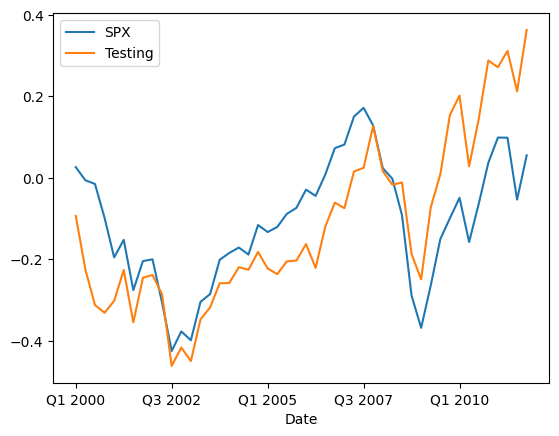

In [47]:
# CALCULATE THE CUMULATIVE RETURN OF THE SPX AND OPTIMAL PORTFOLIO OVER TESTING YEARS 
SPX_cm_return = cumulative_return(return_QQ["SPX"][0:48].tolist())
testing_cm_return = cumulative_return(testing_return_QQ.tolist())

testing_dates = pd.Series(amend_quarterly_dates(return_dates[0:48]))

dict = {
    "Date": testing_dates, 
    "SPX": SPX_cm_return, 
    "Testing": testing_cm_return
}
temp = pd.DataFrame(dict)
temp.set_index('Date', inplace=True)
temp.plot()

Reversing the training and testing data, means that we are using future data to indentify the key choices for the past. With the foresight, we unsurprisingly are able to outpace the SPX. Together with the analysis above this reveals that using a large piece of past data to predict a long distance into the future doesn't hold a lot of weight.  

### Part f) Suppose instead of holding the weight constant, you can rebalance each quarter. You can choose any training window you deem fit (be careful of look-ahead bias!). How does the portfolio perform now?

In [48]:

def oneyear_lookback_simulation(stocks, quarterly_returns, r_f): 
    # calculates the weights that should be allocated to the current years portfolio based on the previous years max sharpe ratio 
    returns = []

    for i in range(len(quarterly_returns)-5):
        ## SLICE DATA 
        # current years data (3+i is "today") 
        previous_4_quarters = quarterly_returns.loc[0+i:3+i]
        
        # next quarter "future" (4+i is "tomorrow")
        next_quarter = quarterly_returns.loc[4+i:4+i]

        ## CALCULATE MEAN RETURN AND COV 
        previous_4_quarters_mean = previous_4_quarters.mean() * 4 
        previous_4_quarters_cov = previous_4_quarters.cov() * 2 

        ## APPROXIMATE OPTIMAL PORTFOLIO 
        output, weights, max_sharpe, opt_weights_dict = simulate_portfolios(1000, stocks, previous_4_quarters_mean, previous_4_quarters_cov, r_f)

        ## EVALUATE PERFORMANCE ON FUTURE YEAR 
        opt_weights = opt_weights_dict["weights"]

        future_return = np.dot(next_quarter, opt_weights)[0]

        returns.append(future_return)

    return returns


In [49]:
simulated_returns = oneyear_lookback_simulation(tickers,return_QQ[tickers], risk_free_rate)

<Axes: xlabel='Date'>

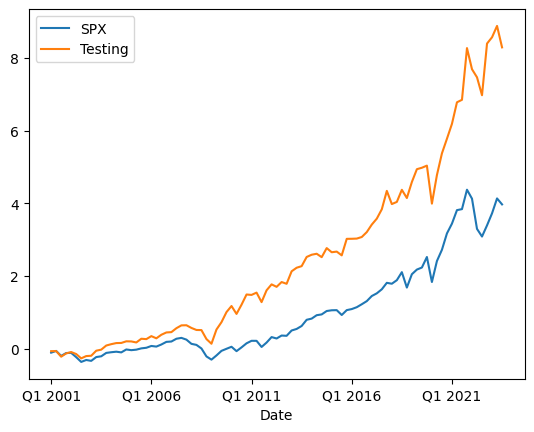

In [50]:
SPX_cm_return = cumulative_return(return_QQ["SPX"][4:len(return_QQ)-1].tolist())
testing_cm_return = cumulative_return(simulated_returns)

testing_dates = pd.Series(amend_quarterly_dates(return_dates[4:len(return_dates)-1]))

dict = {
    "Date": testing_dates, 
    "SPX": SPX_cm_return, 
    "Testing": testing_cm_return
}
temp = pd.DataFrame(dict)
temp.set_index('Date', inplace=True)
temp.plot()

In this simulation we use the previous four quarters to indentify the optimal portfolio for the next quarter. With rebalancing the portfolio is able to outpace the S&P 500 index. 

### Part g) This exercise has been very hypothetical, in reality you typically cannot deviate too much from the index/mandate. What if you must allocate between 5% - 15% to each stock, what do you think the result will be?

In [51]:
# FUNCTION THAT CREATES A RANDOM COMPONENT WISE BOUNDED VECTOR 
def vector_distance(vector):
    return abs(1 - sum(vector))

def rand_bounded_vector(size, lower_bound, upper_bound): 
    good_run = False
    start_time = time.time()

    while good_run != True:
        good_run = True
        vector = []
        for i in range(size): 
            vector.append(random.uniform(0.05,0.15))

        if sum(vector) == 1: 
            return vector
        
        else:
            v_sum = sum(vector)

            
            while v_sum != 1: 
                d = vector_distance(vector)
                index = random.randrange(size)

                if (time.time()-start_time) > 1: 
                    good_run = False
                    break


                if v_sum < 1: 
                    index_d = 0.15 - vector[index]

                    if index_d == 0: 
                        pass
                    elif index_d >= d: 
                        vector[index] += d
                    else: 
                        vector[index] = 0.15
                    
                    v_sum = sum(vector)
                else: 
                    index_d = vector[index] - 0.05
                    
                    if index_d == 0:
                        pass
                    elif index_d >= d: 
                        vector[index] -= d
                    else: 
                        vector[index] = 0.05
                    v_sum = sum(vector)
                    
        return vector


In [52]:
# CREATE A FUNCTION THAT SIMULATES X PORTFOLIOS BASED OF QUARTERLY RETURN DATA 
def simulate_portfolios_bounded(n, stocks, mean_return, cov, r_f): 

    simluated_portfolios = pd.DataFrame(columns=['returns', 'std', 'sharpe'], index = range(n))
    weights = []
    for i in range(n):
        # generate random vector that sums to 1 and has values between (0.05,0.15)
        rand_vec_norm = pd.Series(rand_bounded_vector(len(stocks),0.05,0.15))

        # calculate portfolio return  
        random_portfolio_return = np.dot(rand_vec_norm, mean_return.tolist())
        
        # calculate portfolio standard deviation
        random_portfolio_std = np.sqrt(np.dot(np.dot(rand_vec_norm.T,cov),rand_vec_norm)) 

        # calculate sharpe ratio 
        random_portfolio_sharpe = (random_portfolio_return - r_f)/random_portfolio_std
        
        # append to data frame 
        simluated_portfolios.loc[i, "returns"] = random_portfolio_return
        simluated_portfolios.loc[i,"std"] = random_portfolio_std
        simluated_portfolios.loc[i,"sharpe"] = random_portfolio_sharpe
        weights.append(rand_vec_norm)

    max_sharpe = max(simluated_portfolios["sharpe"])

    index = simluated_portfolios.index[simluated_portfolios["sharpe"] == max_sharpe].tolist()[0]

    opt_weights = weights[index]

    opt_weights_dict = {"tickers": tickers, "weights": opt_weights}
        
    return simluated_portfolios, weights, max_sharpe, opt_weights_dict

In [53]:
# RUN SIMULATION 
output, weights, max_sharpe, opt_weights = simulate_portfolios_bounded(100000, tickers, ticker_return, ticker_cov, risk_free_rate)

<AxesSubplot:xlabel='std', ylabel='returns'>

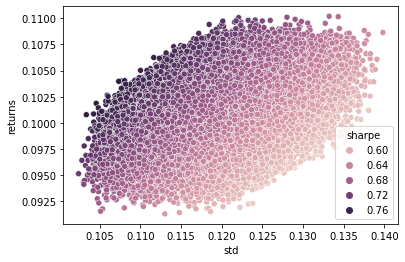

In [109]:
# PLOT SIMULATED DATA 
X = output["std"]
Y = output["returns"]
Z = output["sharpe"]

sb.scatterplot(data= output, x=X, y=Y, hue= Z)

In [54]:
present_weights = pd.DataFrame(opt_weights)
present_weights["weights"] = np.round(present_weights["weights"],2) *100

print("Max Sharpe:", np.round(max_sharpe, 2))
print("Max Sharpe Portfolio Weights:")
print(present_weights)

Max Sharpe: 0.77
Max Sharpe Portfolio Weights:
  tickers  weights
0     PFE      5.0
1     XOM     13.0
2     MCD     15.0
3       F      6.0
4     WMT     14.0
5     HON      6.0
6      PG     15.0
7     MMM      5.0
8     JPM      6.0
9    MSFT     15.0


Since we are futher constraining the optimization problem, we can expect that the Sharpe Ratio may decrease as a result. If the optimal portfolio had already lied within the 0.05-0.15 for each asset then we would have seen no change. Running the simulation again under this constrained condition we find that the Sharpe ratio decreased from 0.87 (unconstrained problem) to 0.77.

### Part h) In your opinion, does the Sharpe Ratio serve as a good measurement of portfolio performance? What does it not capture and what would you use instead?

Overall the Sharpe ratio is an effective tool in measuring portfolio performance and can serve as an effective means of allocating a portfolio. It is however critical that the sharpe ratio in each period (i.e year) is maximized rather than the sharpe ratio over an entire period (i.e. 10 years). The sharpe ratio statistically depends on variance as the means of attributing risk. This often implies a normality assumption which may be generous in some circumstances. It also places a focus on the first and second moments of the distribution; meaning that there is some nature of the risk that is not effectively captured. Two alternatives to the Sharpe ratio would be the Sortino ratio, covering the downside variance only, or the Treynor ratio, using a portfolios beta.  